In [283]:
import numpy as np
import seaborn as sn
import tensorflow as tf
import pandas as pd
import scipy.io as spio
from pathlib import Path
from math import floor, ceil
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import plotly
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
CONTROL_DICT = {
    "EPOCHS": 20,
    "cross_validation_size": 0.7,
    "model_parameters": {
        "optimizer": "adam",
        "loss_function": "mse",
        "first_layer": {
            "neurons": 50,
            "activation_function": "tanh"
        },
        "second_layer": {
            "neurons": 50,
            "activation_function": "tanh"
        }
    }
}

In [168]:
def get_model(model_selector: str, train_x: dict) -> Sequential:
    model = Sequential()
    if model_selector == "VLSTM": #Vanilla LSTM        
        model.add(
            LSTM(units=CONTROL_DICT["model_parameters"]["first_layer"]["neurons"], 
                activation=CONTROL_DICT["model_parameters"]["first_layer"]["activation_function"],
                input_shape=train_x[0].shape))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
    elif model_selector == "SLSTM": #Stacked LSTM
        model.add(LSTM(units=CONTROL_DICT["model_parameters"]["first_layer"]["neurons"], 
                     activation=CONTROL_DICT["model_parameters"]["first_layer"]["activation_function"], 
                     return_sequences=True, 
                     input_shape=train_x[0].shape))
        model.add(LSTM(units=CONTROL_DICT["model_parameters"]["second_layer"]["neurons"], 
                       activation=CONTROL_DICT["model_parameters"]["second_layer"]["activation_function"]))
        model.add(Dense(1))
        model.compile(optimizer=CONTROL_DICT["model_parameters"]["optimizer"], 
                      loss=CONTROL_DICT["model_parameters"]["loss_function"])
        
    return model

def get_preiction_precision_on_class(class_no, df):
    a = df[df["real"] == class_no]
    n = a["predicted"] - a["real"]
    print(len(n[n==0]) / a.shape[0])

Import of data 

In [119]:
train_set = spio.loadmat("../deepFold_train", squeeze_me=True)
test_set = spio.loadmat("../deepFold_test", squeeze_me=True)

In [132]:
X_train = train_set["x_train"][:ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["x_train"]))]
y_train = pd.DataFrame(train_set["y_train"])[[0]].iloc[:ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["y_train"]))]

X_cv = train_set["x_train"][ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["x_train"])):]
y_cv = pd.DataFrame(train_set["y_train"])[[0]].iloc[ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["y_train"])): ]

X_test = test_set["x_test"]
y_test = pd.DataFrame(test_set["y_test"])[[0]]

Construction of model



In [4]:
model = get_model(model_selector="SLSTM", 
                  train_x=X_train)
model.fit(x=X_train, 
          y=y_train, 
          epochs=CONTROL_DICT["EPOCHS"], 
          verbose=1, 
          shuffle=False)

Epoch 1/50
7958/7958 [==============================] - 151s 19ms/step - loss: 0.4009
Epoch 2/50
7958/7958 [==============================] - 135s 17ms/step - loss: 0.3329
Epoch 3/50
7958/7958 [==============================] - 138s 17ms/step - loss: 0.2993
Epoch 4/50
7958/7958 [==============================] - 147s 18ms/step - loss: 0.2753
Epoch 5/50
7958/7958 [==============================] - 143s 18ms/step - loss: 0.2639
Epoch 6/50
7958/7958 [==============================] - 138s 17ms/step - loss: 0.2570
Epoch 7/50
7958/7958 [==============================] - 139s 17ms/step - loss: 0.2524
Epoch 8/50
7958/7958 [==============================] - 138s 17ms/step - loss: 0.2490
Epoch 9/50
7958/7958 [==============================] - 137s 17ms/step - loss: 0.2465
Epoch 10/50
7958/7958 [==============================] - 137s 17ms/step - loss: 0.2442
Epoch 11/50
7958/7958 [==============================] - 142s 18ms/step - loss: 0.2416
Epoch 12/50
7958/7958 [=============================

In [137]:
y_pred = model.predict(X_test, verbose=1)

4353/4353 [==============================] - 97s 17ms/step


In [181]:
target_names = [1, 2, 3]
print(classification_report(y_true=test_y, y_pred=pd.Series(y_pred.mean(axis=1).round()).astype(int), labels=target_names))

              precision    recall  f1-score   support

           1       0.85      0.40      0.54     21054
           2       0.80      0.98      0.88     98534
           3       0.85      0.39      0.53     19702

    accuracy                           0.81    139290
   macro avg       0.83      0.59      0.65    139290
weighted avg       0.81      0.81      0.78    139290



In [182]:
df = pd.DataFrame(columns=["predicted", "real"])
df["predicted"] = pd.Series(y_pred.ravel().round()).astype(int)
df["real"] = test_y[0]


In [183]:
get_preiction_precision_on_class(1,df)
get_preiction_precision_on_class(2,df)
get_preiction_precision_on_class(3,df)


0.06255343402678826
0.8709379503521627
0.060146178052989545


In [228]:
n = (pd.DataFrame(y_pred).mean(axis=1).round().astype(int) - test_y[0])
len(n[n==0]) / y_pred.shape[0]

df = pd.DataFrame(columns=["predicted", "real"])
df["predicted"] = pd.Series(y_pred.mean(axis=1).round()).astype(int)
df["real"] = test_y[0]


get_preiction_precision_on_class(1,df)
get_preiction_precision_on_class(2,df)
get_preiction_precision_on_class(3,df)
a = df.groupby("real")

0.3958392704474209
0.9779162522581037
0.38620444624911177


<AxesSubplot:>

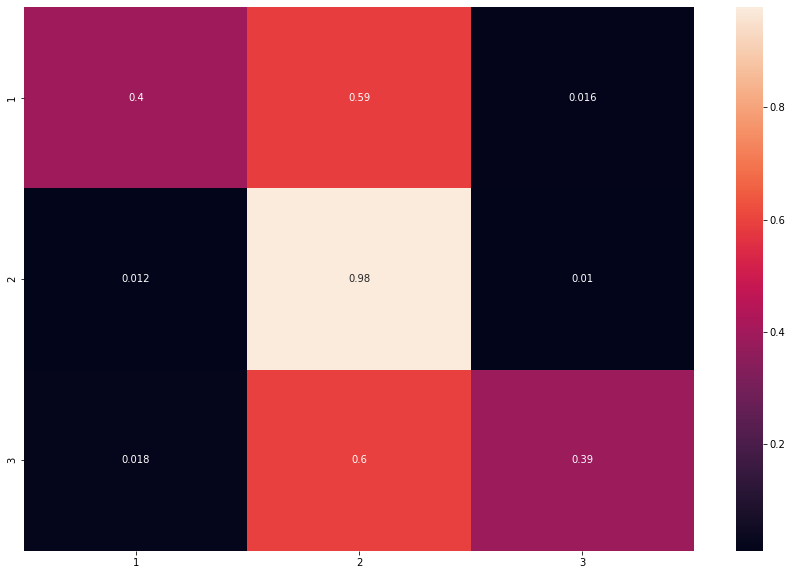

In [295]:
t1 = a.get_group(1).groupby("predicted").count()
t2 = a.get_group(2).groupby("predicted").count()
t3 = a.get_group(3).groupby("predicted").count()


plt.figure(figsize = (15,10))
df_cm = pd.DataFrame(confusion_matrix(df.real, df.predicted, normalize="true"), range(1,4,1), range(1,4,1))
sn.heatmap(df_cm, annot=True)


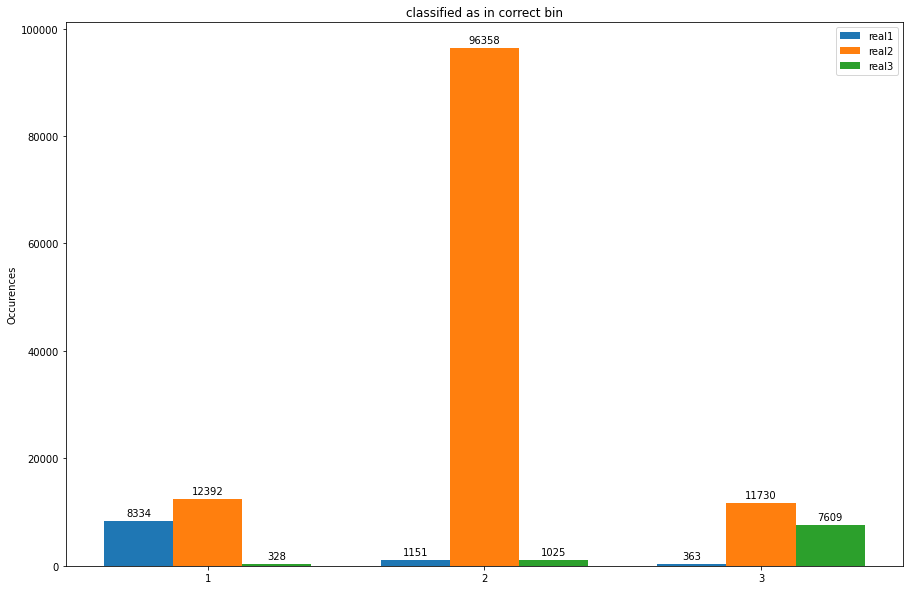

In [258]:
plt.rcParams['figure.figsize'] = [15, 10]
labels = t1.index
x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots()
first_data_bar = [t1.real.loc[1], t2.real.loc[1], t3.real.loc[1]]
second_data_bar = [t1.real.loc[2], t2.real.loc[2], t3.real.loc[2]]
third_data_bar = [t1.real.loc[3], t2.real.loc[3], t3.real.loc[3]]


rects1 = ax.bar(x - width, first_data_bar, width, label='real1')
rects2 = ax.bar(x, second_data_bar, width, label='real2')
rects3 = ax.bar(x + width, third_data_bar, width, label='real3')
ax.set_ylabel('Occurences')
ax.set_title('classified as in correct bin')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

#fig.tight_layout()

plt.show()

In [268]:


print("Correct classified percentage of class 1 is: {}%".format(round(((t1.real.loc[1]*100)/t1.real.sum()),3)))
print("Correct classified percentage of class 2 is: {}%".format(round(((t2.real.loc[2]*100)/t2.real.sum()),3)))
print("Correct classified percentage of class 3 is: {}%".format(round(((t3.real.loc[3]*100)/t3.real.sum()),3)))
print("Correct percentage of testset 1 realtion between predicted 1 and 3 is: {}%".format(round(((t1.real.loc[1]*100)/(t1.real.loc[1]+ t1.real.loc[3])),3)))
print("Correct percentage of testset 3 realtion between predicted 1 and 3 is: {}%".format(round(((t3.real.loc[3]*100)/(t3.real.loc[1]+ t3.real.loc[3])),3)))



correct classified percentage of class 1 is: 39.584%
correct classified percentage of class 2 is: 97.792%
correct classified percentage of class 3 is: 38.62%
correct percentage of testset 1 realtion between predicted 1 and 3 is: 96.213%
correct percentage of testset 3 realtion between predicted 1 and 3 is: 95.447%


0.9544656297039639